# Results visualisation

base_models - models with base arcitecture 

new_models - models with the second arcitecture  

In [1]:
base_dir = r"experiment_results\reordered_models"

base_models = [f"base_model_{i}" for i in range(4,10)]
new_models = [f"second_model_{i}" for i in range(4,10)]
experiments = base_models + new_models
random_models = [f"{name}_r" for name in experiments]

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import json

METHOD = "hmm_pomegranate"
from hmm_logic_methods import  load_model
from hmm_visualization_methods import *
from training_parameters import *

import training_parameters
from data_reading_methods import *


In [3]:
def read_json(filename, target_path):
    path = os.path.join(target_path, filename)
    
    # Check if the file exists
    if not os.path.isfile(path):
        raise FileNotFoundError(f"The file {path} does not exist.")
    
    # Read the JSON data from the file
    with open(path, 'r') as file:
        data = json.load(file)
    
    return data


In [5]:
# Function to process data
def extract_data(model_data, model_name):
    for allele, splits in model_data.items():
        for split, metrics in splits.items():
            for metric, value in metrics.items():
                data.append({
                    'allele': allele,
                    'split': split,
                    'model': model_name,
                    'metric': metric,
                    'value': value
                })


In [4]:
metrics = {}
results_score = {}
y_true = {}

metrics_r = {}
results_score_r = {}
y_true_r = {}

for experiment in experiments:
    experiment_subdir = f"{base_dir}/{experiment}"

    metrics[f"{experiment}_nb"] = read_json("metrics.json", experiment_subdir)
    results_score[f"{experiment}_nb"] = read_json("result_scores.json", experiment_subdir)
    y_true[f"{experiment}_nb"] = read_json("y_true.json", experiment_subdir)


    metrics[f"{experiment}_r"] = read_json("metrics_r.json", experiment_subdir)
    results_score[f"{experiment}_r"] = read_json("result_scores_r.json", experiment_subdir)
    y_true[f"{experiment}_r"] = read_json("y_true_r.json", experiment_subdir)

## AUC scores for all models

We calculated the following metric ['accuracy', 'precision', 'recall', 'f1', 'auc']

AUC scores will be visualised with boxplotes

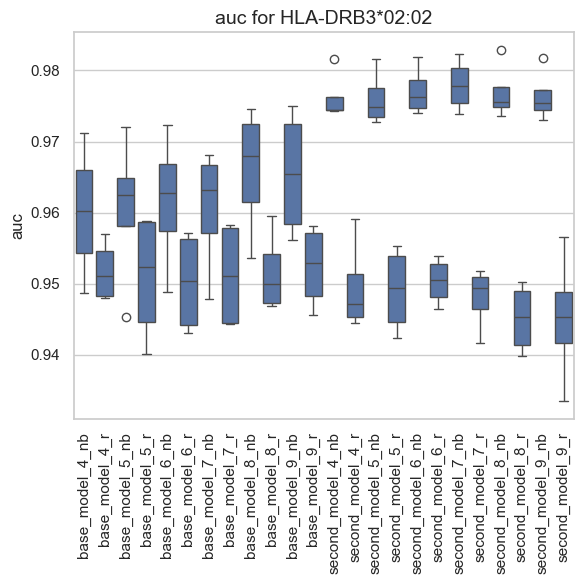

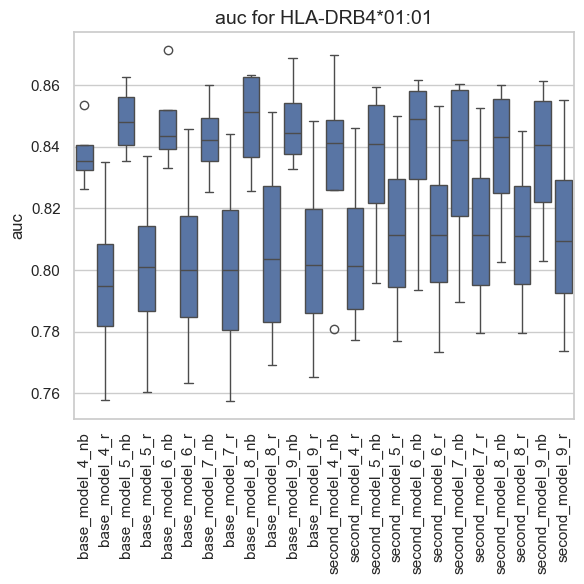

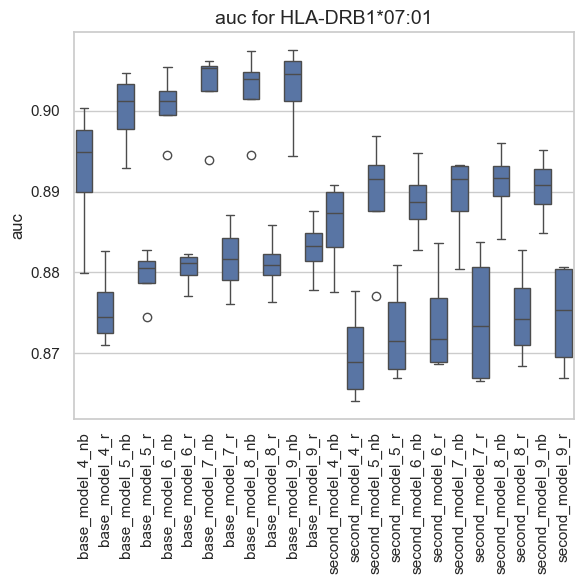

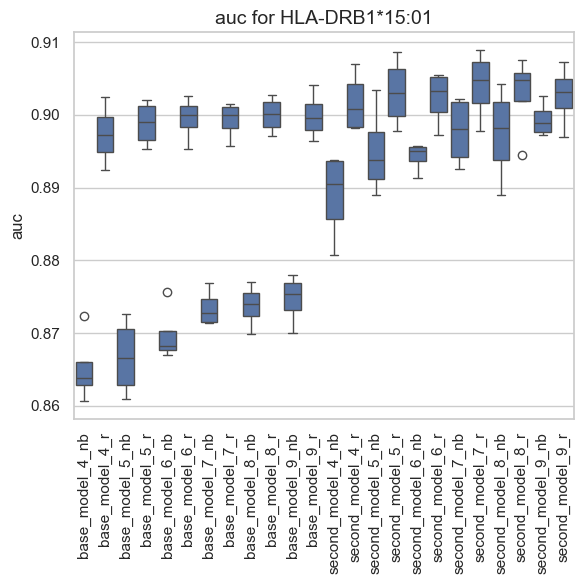

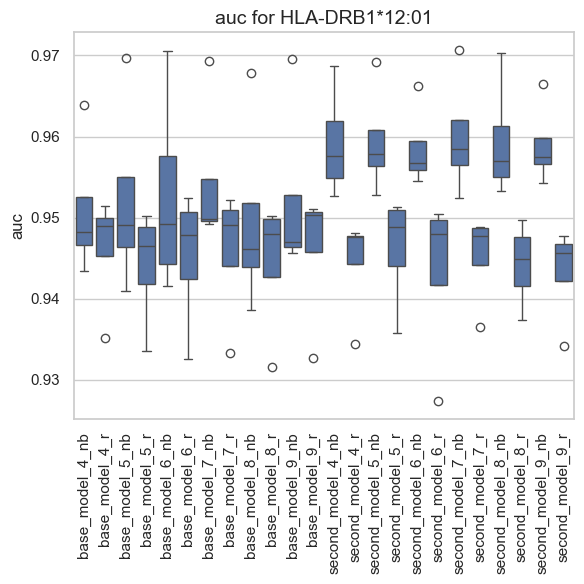

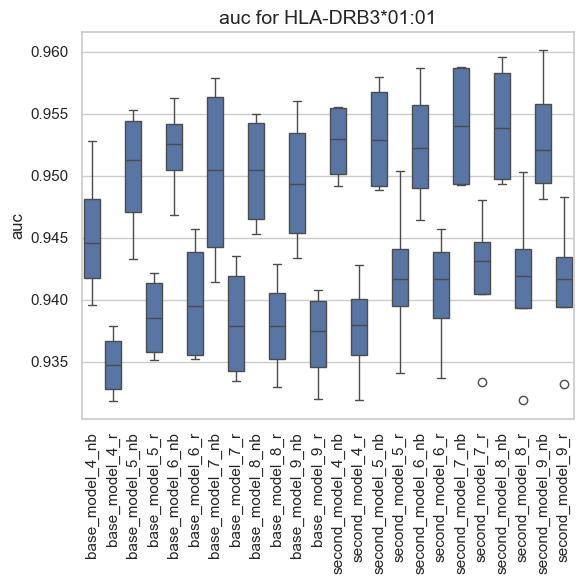

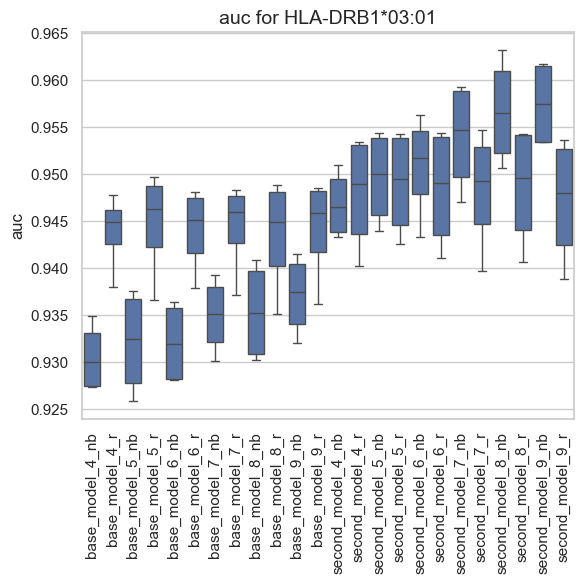

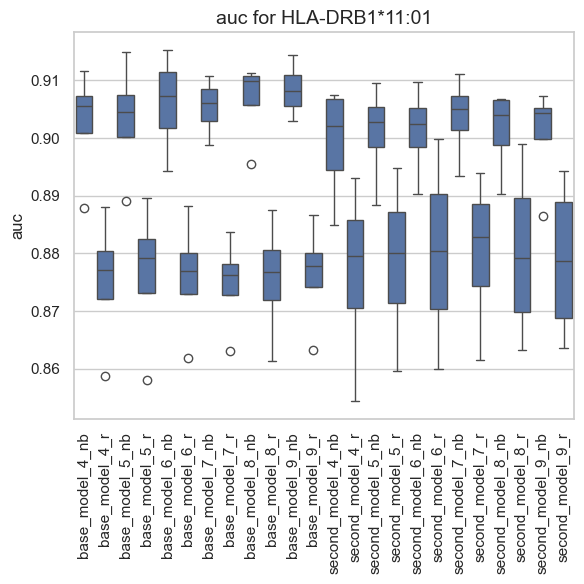

In [ ]:
data = []

for expirement, metric in metrics.items():
    extract_data(metric, expirement)

df = pd.DataFrame(data)

alleles = df['allele'].unique()

sns.set(style="whitegrid")


metrics_names = ['auc']


for metric in metrics_names:
    for allele in alleles:
        plt.figure(figsize=(6, 6))
        plt.title(f'{metric} for {allele}', fontsize=14)
        
        sns.boxplot(x='model', y='value', data=df[(df['metric'] == metric) & (df['allele'] == allele) & (df['allele'] == allele)])
        
        plt.xlabel('')
        plt.ylabel(metric)
        plt.xticks(rotation=90)  
        
        plt.tight_layout()
        allele_formated = allele.replace('-', '_').replace('*', '_').replace(':', '_').replace('/', '_')
        

        plt.savefig(f"plots//{metric}_{allele_formated}.png", dpi=300)  
        plt.show()
        plt.close()  


We can see that there is no common pattern for all alleles in case of anchor_top_aas parameter and typee of architecture. 

## Anchor state parameter 

In [25]:
base_models = {key: y_true[key] for key in y_true.keys() if key.startswith('base_')}
second_models = {key: y_true[key] for key in y_true.keys() if key.startswith('second_')}

**Boxplots of AUC splits scores of two architectures calculated using nonbinders**

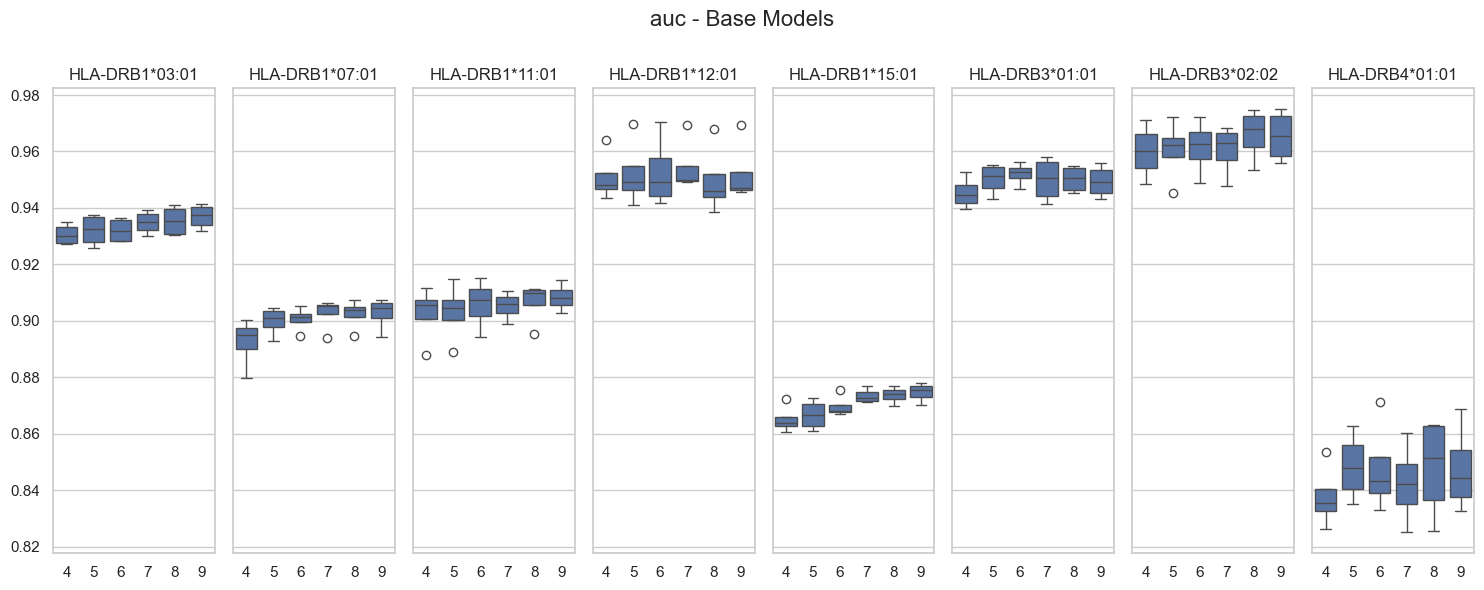

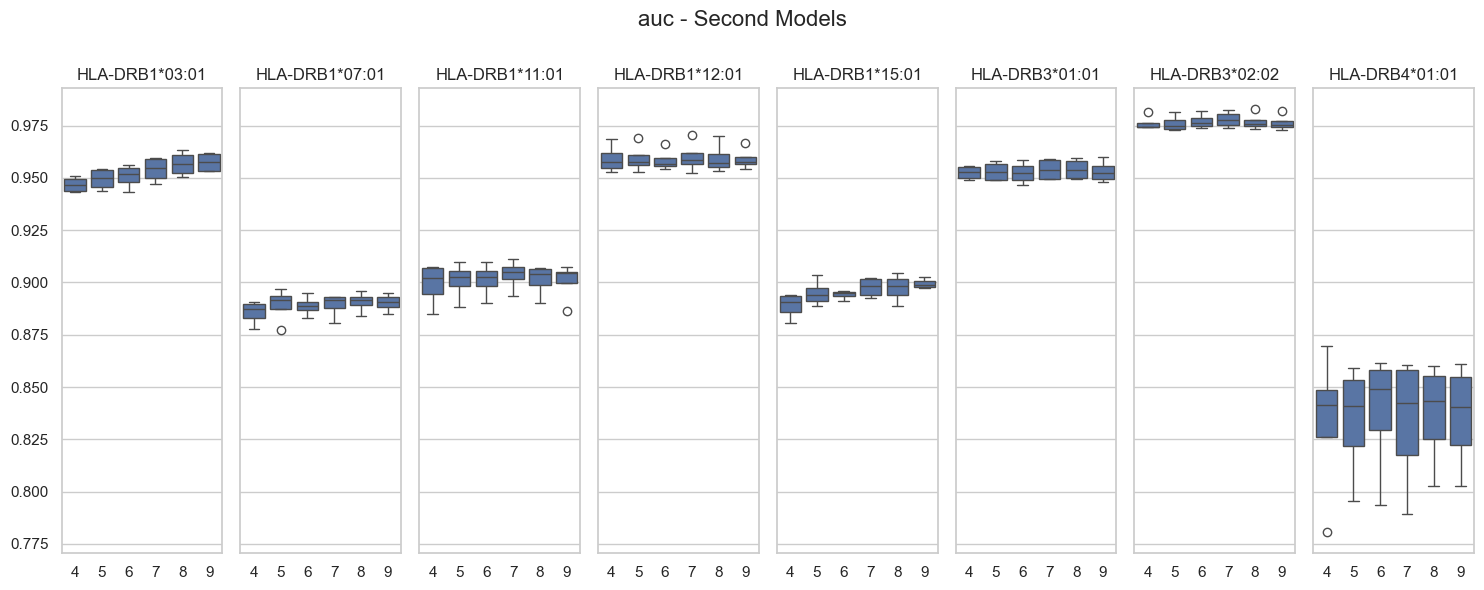

In [ ]:
def simplify_model_name(name):
    if name.endswith('_nb'):
        for i, char in enumerate(name):
            if char.isdigit():
                return name[i:i+1]
    return None  

for metric in metrics_names:
    fig, axes = plt.subplots(1, len(alleles), figsize=(15, 6), sharey=True)
    fig.suptitle(f'{metric} - Base Models', fontsize=16)

    for i, allele in enumerate(alleles):
        df = base_models[(base_models['metric'] == metric) & (base_models['allele'] == allele)].copy()
        df['model'] = df['model'].apply(simplify_model_name)

        sns.boxplot(x='model', y='value', data=df, ax=axes[i])
        axes[i].set_title(allele)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f"plots//{metric}_base_models.png", dpi=300)
    plt.show()

    fig, axes = plt.subplots(1, len(alleles), figsize=(15, 6), sharey=True)
    fig.suptitle(f'{metric} - Second Models', fontsize=16)

    for i, allele in enumerate(alleles):
        df = second_models[(second_models['metric'] == metric) & (second_models['allele'] == allele)].copy()
        df['model'] = df['model'].apply(simplify_model_name)

        sns.boxplot(x='model', y='value', data=df, ax=axes[i])
        axes[i].set_title(allele)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f"plots//{metric}_second_models.png", dpi=300)
    plt.show()


The analysis shows significant variability in optimal parameters across different alleles, precluding the identification of a single best value. These results demonstrate that predictive performance can only be optimized through allele-specific adjustment of the anchor state parameter

## Non-binders vs random peptides scoring

In [28]:
from sklearn.metrics import roc_curve, auc
import numpy as np
from scipy.stats import ttest_ind

In [ ]:
color_nb = 'blue'
color_r = 'red'

In [ ]:
def plot_roc_scoring(models, title_prefix):
    alleles = list(models.values())[0].keys()  
    num_alleles = len(alleles)
    n_rows, n_cols = 2, (num_alleles + 1) // 2  
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=True, sharey=True)
    fig.suptitle(f'ROC curves - {title_prefix} Models', fontsize=24)
    axes = axes.flatten()

    auc_values = {'Non-binders': [], 'Randoms': []}  

    for i, allele in enumerate(alleles):
        ax = axes[i]
        ax.set_title(f'Allele: {allele}',  fontsize=16)


        ax.grid(False)

        auc_nb_list, auc_r_list = [], []  
        
        for model_name, model_data in models.items():
            y_true_allele = model_data[allele]
            results_score_allele = results_score[model_name][allele]
            
            if isinstance(y_true_allele, dict) and isinstance(results_score_allele, dict):
                for split in y_true_allele:
                    y_true_split = y_true_allele[split]
                    results_split = results_score_allele[split]
                    
                    fpr, tpr, _ = roc_curve(y_true_split, results_split)
                    roc_auc = auc(fpr, tpr)
                    
                    if '_nb' in model_name:
                        color, label = 'blue', "Non-binders"
                        auc_nb_list.append(roc_auc)
                    else:
                        color, label = 'red', "Randoms"
                        auc_r_list.append(roc_auc)
                    
                    ax.plot(fpr, tpr, color=color, alpha=0.6)

        p_value = ttest_ind(auc_nb_list, auc_r_list, equal_var=False).pvalue if auc_nb_list and auc_r_list else np.nan
        
        ax.text(0.5, 0.2, f'AUC =: {np.mean(auc_nb_list):.2f}', color='blue')
        ax.text(0.5, 0.125, f'AUC =: {np.mean(auc_r_list):.2f}', color='red')
        ax.text(0.5, 0.05, f'p-value: {p_value:.3g}', color='black')
        
        auc_values['Non-binders'].extend(auc_nb_list)
        auc_values['Randoms'].extend(auc_r_list)


    fig.text(0.5, 0.01, 'False Positive Rate', ha='center', fontsize=24)
    fig.text(0.02, 0.5, 'True Positive Rate', va='center', rotation='vertical', fontsize=24)
    

    handles = [plt.Line2D([0], [0], color='blue', lw=2),
               plt.Line2D([0], [0], color='red', lw=2)]
    fig.legend(handles=handles, labels=['Non-binders', 'Randoms'], loc='center right', frameon=False, fontsize=16)
    

    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.subplots_adjust(left = 0.065, right=0.875,  bottom=0.1, top=0.9)  

    # Save and show the figure
    plt.savefig(f"plots/{title_prefix}_ROC_curves.png", dpi=300)
    plt.show()

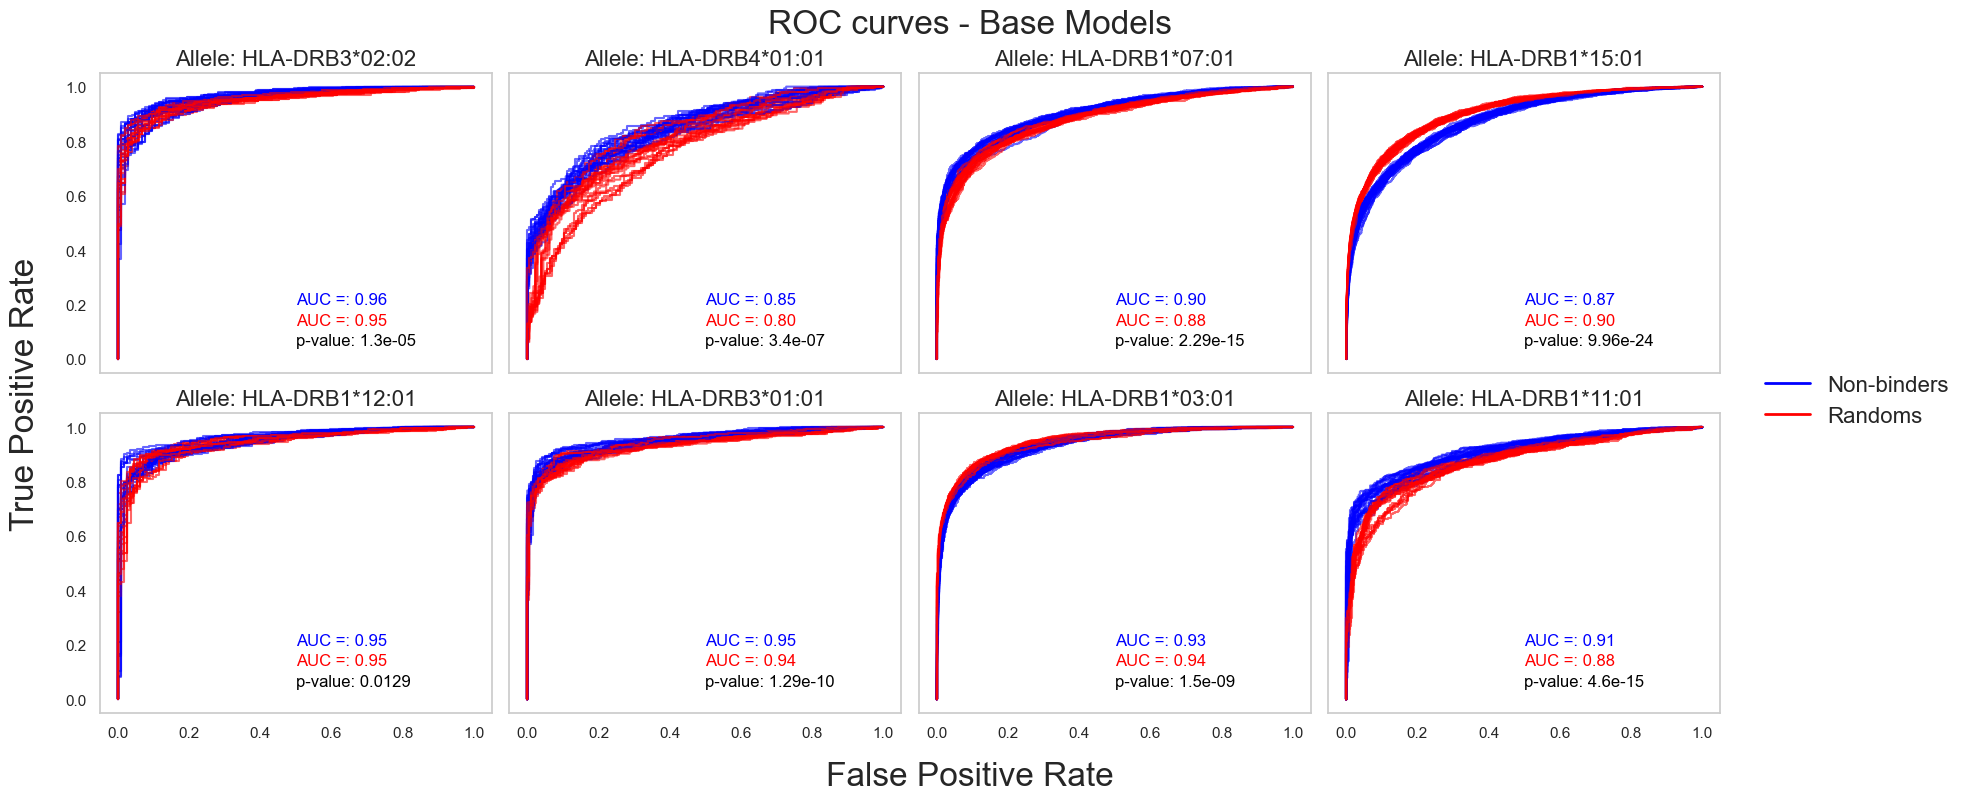

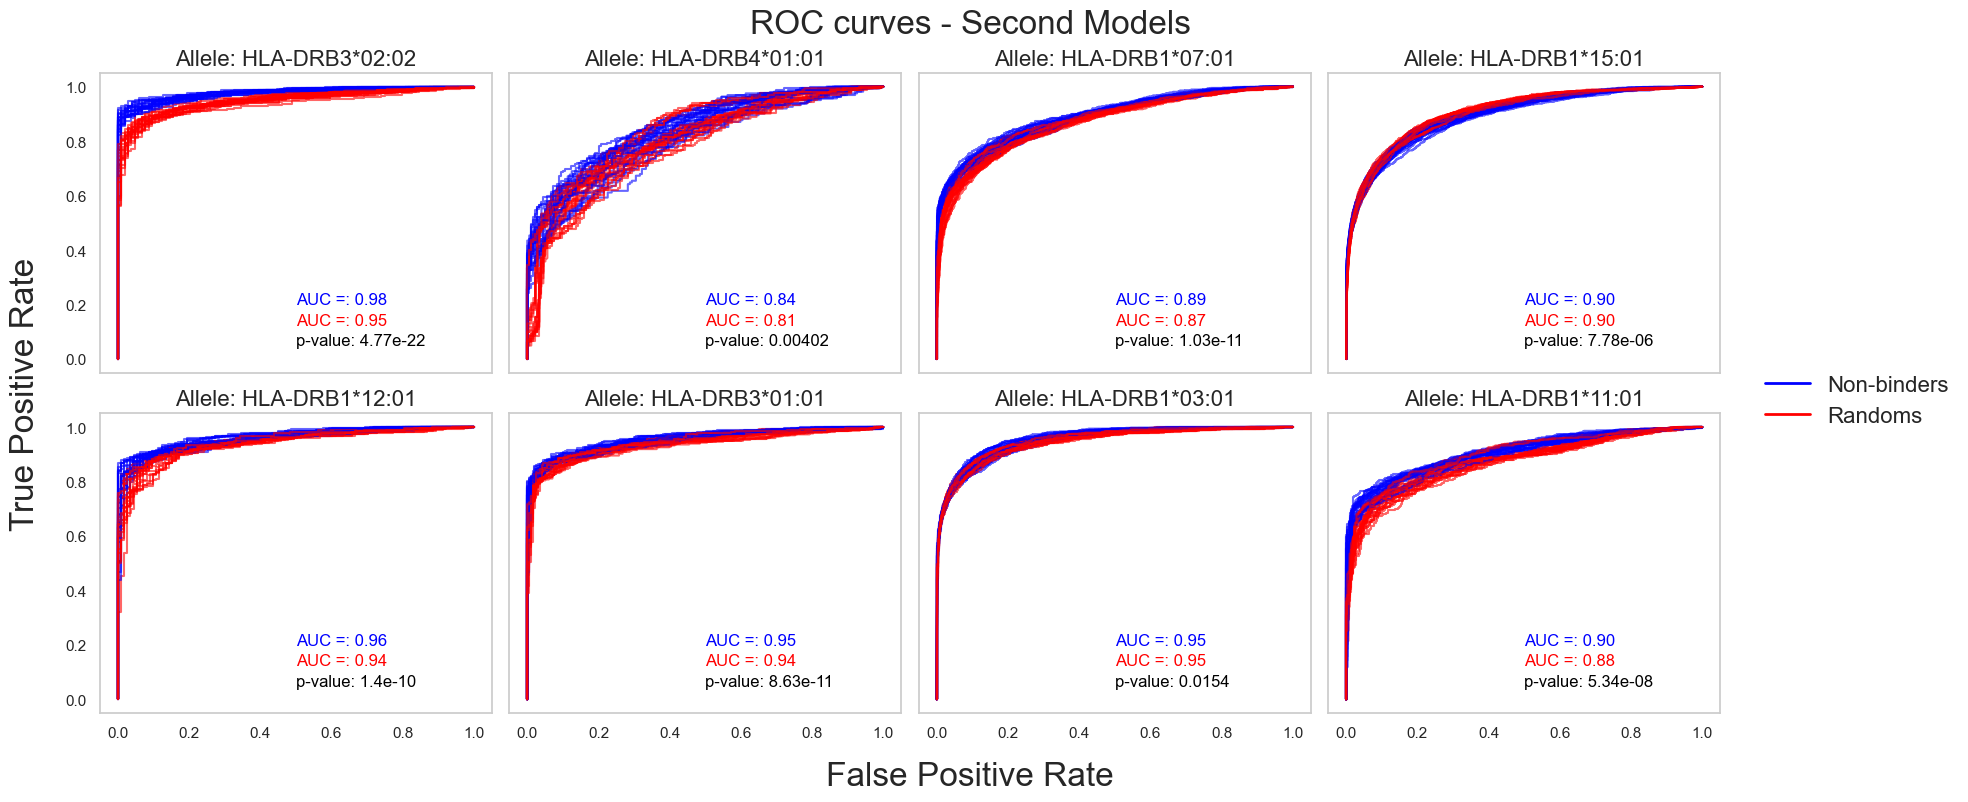

In [39]:
plot_roc_scoring(base_models, 'Base')

plot_roc_scoring(second_models, 'Second')

Using non-binders as the null distribution enhanced AUC scores in the majority of cases—improving 5 of 8 base models and 6 of 8 second-architecture models. The extent of improvement depended on non-binder quality: models performed best when non-binders exhibited high consistency, particularly with 15-mer peptides. Conversely, random-like non-binders (e.g., those in HLA-DRB115:01 and HLA-DRB103:01) degraded performance, making random scoring a more effective alternative. These results underscore the critical role of negative-example structure and quality in model training.

### Length distribution of non-binders

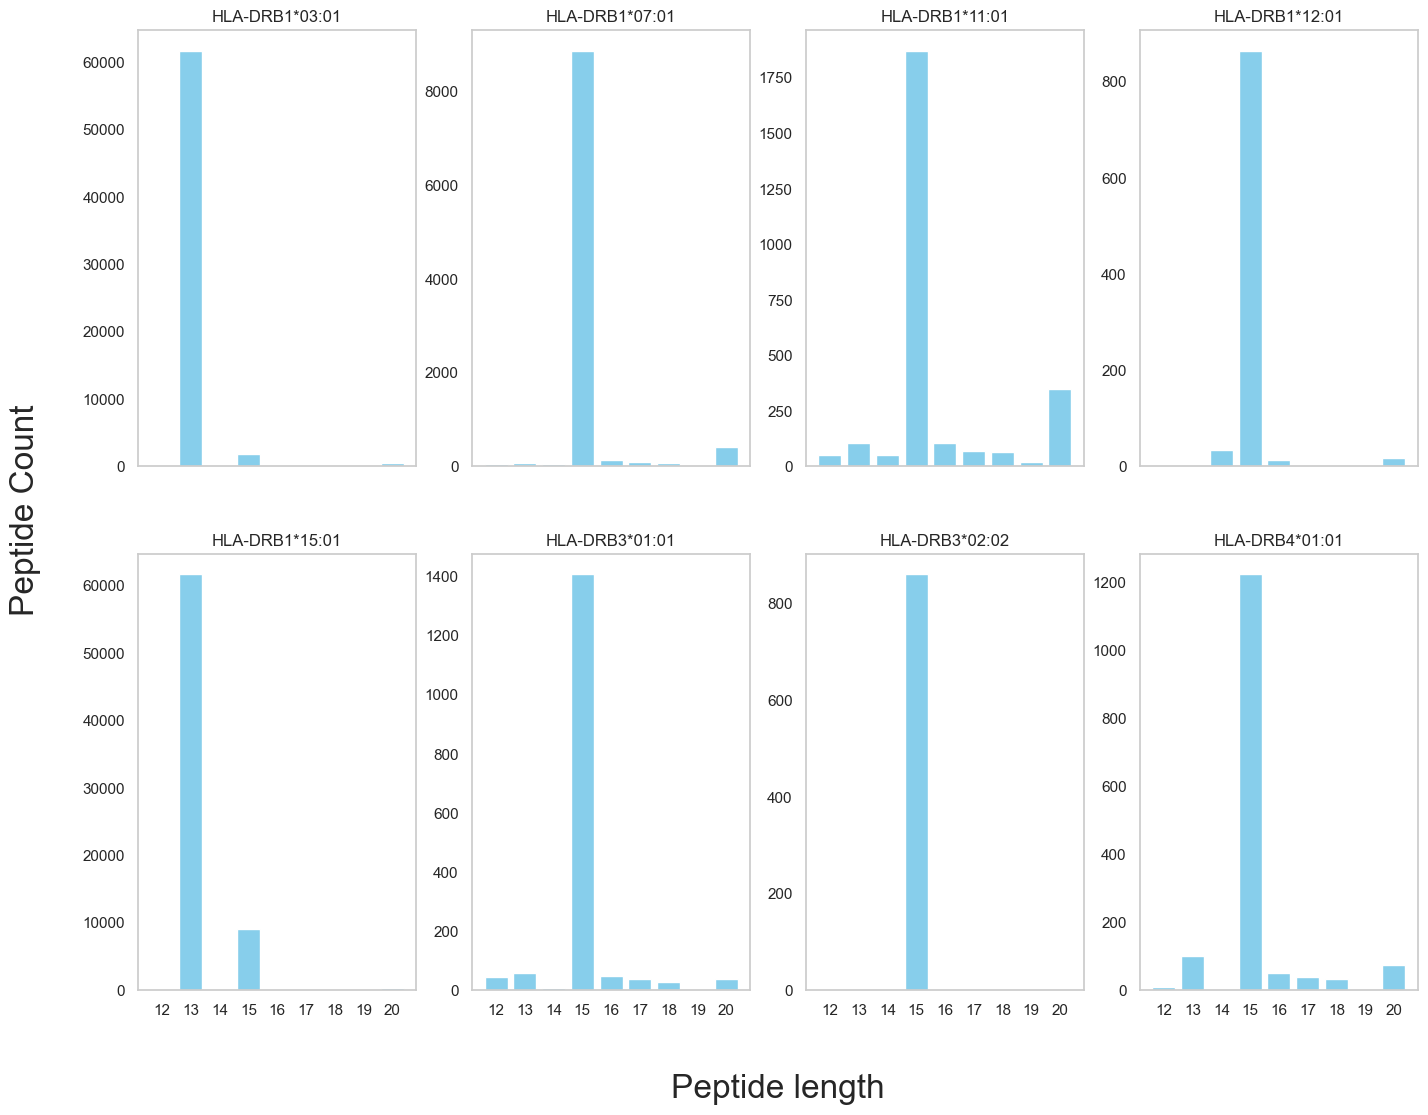

In [ ]:
alleles = [
    "HLA-DRB1*03:01", "HLA-DRB1*07:01", "HLA-DRB1*11:01", "HLA-DRB1*12:01", 
    "HLA-DRB1*15:01", "HLA-DRB3*01:01", "HLA-DRB3*02:02", "HLA-DRB4*01:01"
]

lengths = np.array([12, 13, 14, 15, 16, 17, 18, 19, 20])

counts = {
    "HLA-DRB1*03:01": [63, 61656, 120, 1794, 113, 75, 68, 50, 505],
    "HLA-DRB1*07:01": [55, 76, 54, 8864, 126, 85, 76, 31, 410],
    "HLA-DRB1*11:01": [53, 104, 51, 1871, 104, 69, 65, 19, 350],
    "HLA-DRB1*12:01": [0, 0, 34, 864, 13, 0, 0, 0, 18],
    "HLA-DRB1*15:01": [51, 61651, 43, 9115, 92, 79, 55, 17, 332],
    "HLA-DRB3*01:01": [45, 58, 7, 1407, 49, 38, 28, 0, 36],
    "HLA-DRB3*02:02": [0, 0, 0, 860, 0, 0, 0, 0, 0],
    "HLA-DRB4*01:01": [9, 99, 0, 1223, 49, 38, 31, 0, 73]
}

# Plotting
fig, axs = plt.subplots(2, 4, figsize=(16, 12), sharex=True) 
axs = axs.flatten() 

for i, allele in enumerate(alleles):
    axs[i].bar(lengths, counts[allele], color='skyblue')
    axs[i].set_title(allele)

    axs[i].set_xticks(lengths)
    axs[i].grid(False)

fig.text(0.5, 0.01, 'Peptide length', ha='center', fontsize=24)
fig.text(0.02, 0.5, 'Peptide Count', va='center', rotation='vertical', fontsize=24)
plt.subplots_adjust(left = 0.1, right=0.9,  bottom=0.1, top=0.9)    


plt.savefig(f"plots//count_of_nb", dpi=300)
plt.show()

The quality of non-binder peptides impacts model performance, as evidenced by their length distribution. Models trained on uniform-length non-binders (e.g., mostly 15-mers) perform better.

## Comparing model architectures

In [36]:
color_base = 'blue'
color_second = 'green'

In [ ]:

def plot_roc_for_architectures(base_models, second_models, title_prefix):
    alleles = list(base_models.values())[0].keys()  
    num_alleles = len(alleles)
    
    n_rows = 2
    n_cols = (num_alleles + 1) // 2  
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6), sharex=True, sharey=True)
    axes = axes.flatten() if num_alleles > 1 else [axes]
    
    auc_base_all = []
    auc_second_all = []
    
    for i, allele in enumerate(alleles):
        ax = axes[i]
        ax.set_title(f' {allele} ', fontsize=16)
        ax.grid(False)
        
        auc_base = []
        auc_second = []
        

        for model_name, model_data in base_models.items():
            y_true_allele = model_data[allele]
            results_score_allele = results_score[model_name][allele]
            
            for split in y_true_allele:
                y_true_split = y_true_allele[split]
                results_split = results_score_allele[split]
                
                fpr, tpr, _ = roc_curve(y_true_split, results_split)
                roc_auc = auc(fpr, tpr)
                auc_base.append(roc_auc)
                
                ax.plot(fpr, tpr, color=color_base, alpha=0.6)

        for model_name, model_data in second_models.items():
            y_true_allele = model_data[allele]
            results_score_allele = results_score[model_name][allele]
            
            for split in y_true_allele:
                y_true_split = y_true_allele[split]
                results_split = results_score_allele[split]
                
                fpr, tpr, _ = roc_curve(y_true_split, results_split)
                roc_auc = auc(fpr, tpr)
                auc_second.append(roc_auc)
                
                ax.plot(fpr, tpr, color=color_second, alpha=0.6)
    
        if auc_base and auc_second:
            p_value = ttest_ind(auc_base, auc_second, equal_var=False).pvalue
            ax.text(0.6, 0.05, f'p-value: {p_value:.3g}', transform=ax.transAxes, color='black', fontsize=14)
            ax.text(0.6, 0.2, f'Base AUC: {np.mean(auc_base):.2f}', transform=ax.transAxes, color=color_base, fontsize=14)
            ax.text(0.6, 0.125, f'Second AUC: {np.mean(auc_second):.2f}', transform=ax.transAxes, color=color_second, fontsize=14)
        
               
        
        auc_base_all.extend(auc_base)
        auc_second_all.extend(auc_second)
    
    fig.text(0.5, 0.01, 'False Positive Rate', ha='center', fontsize=24)
    fig.text(0.02, 0.5, 'True Positive Rate', va='center', rotation='vertical', fontsize=24)
    
    legend_elements = [
        plt.Line2D([0], [0], color=color_base, lw=2, label='Base Model'),
        plt.Line2D([0], [0], color=color_second, lw=2, label='Second Model')
    ]
    fig.legend(handles=legend_elements, loc='center right', frameon=False, fontsize=16)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.subplots_adjust(left = 0.065, right=0.875,  bottom=0.1, top=0.9) 
    plt.savefig(f'plots/{title_prefix}_ROC_curves_common.png', dpi=300)
    plt.show()

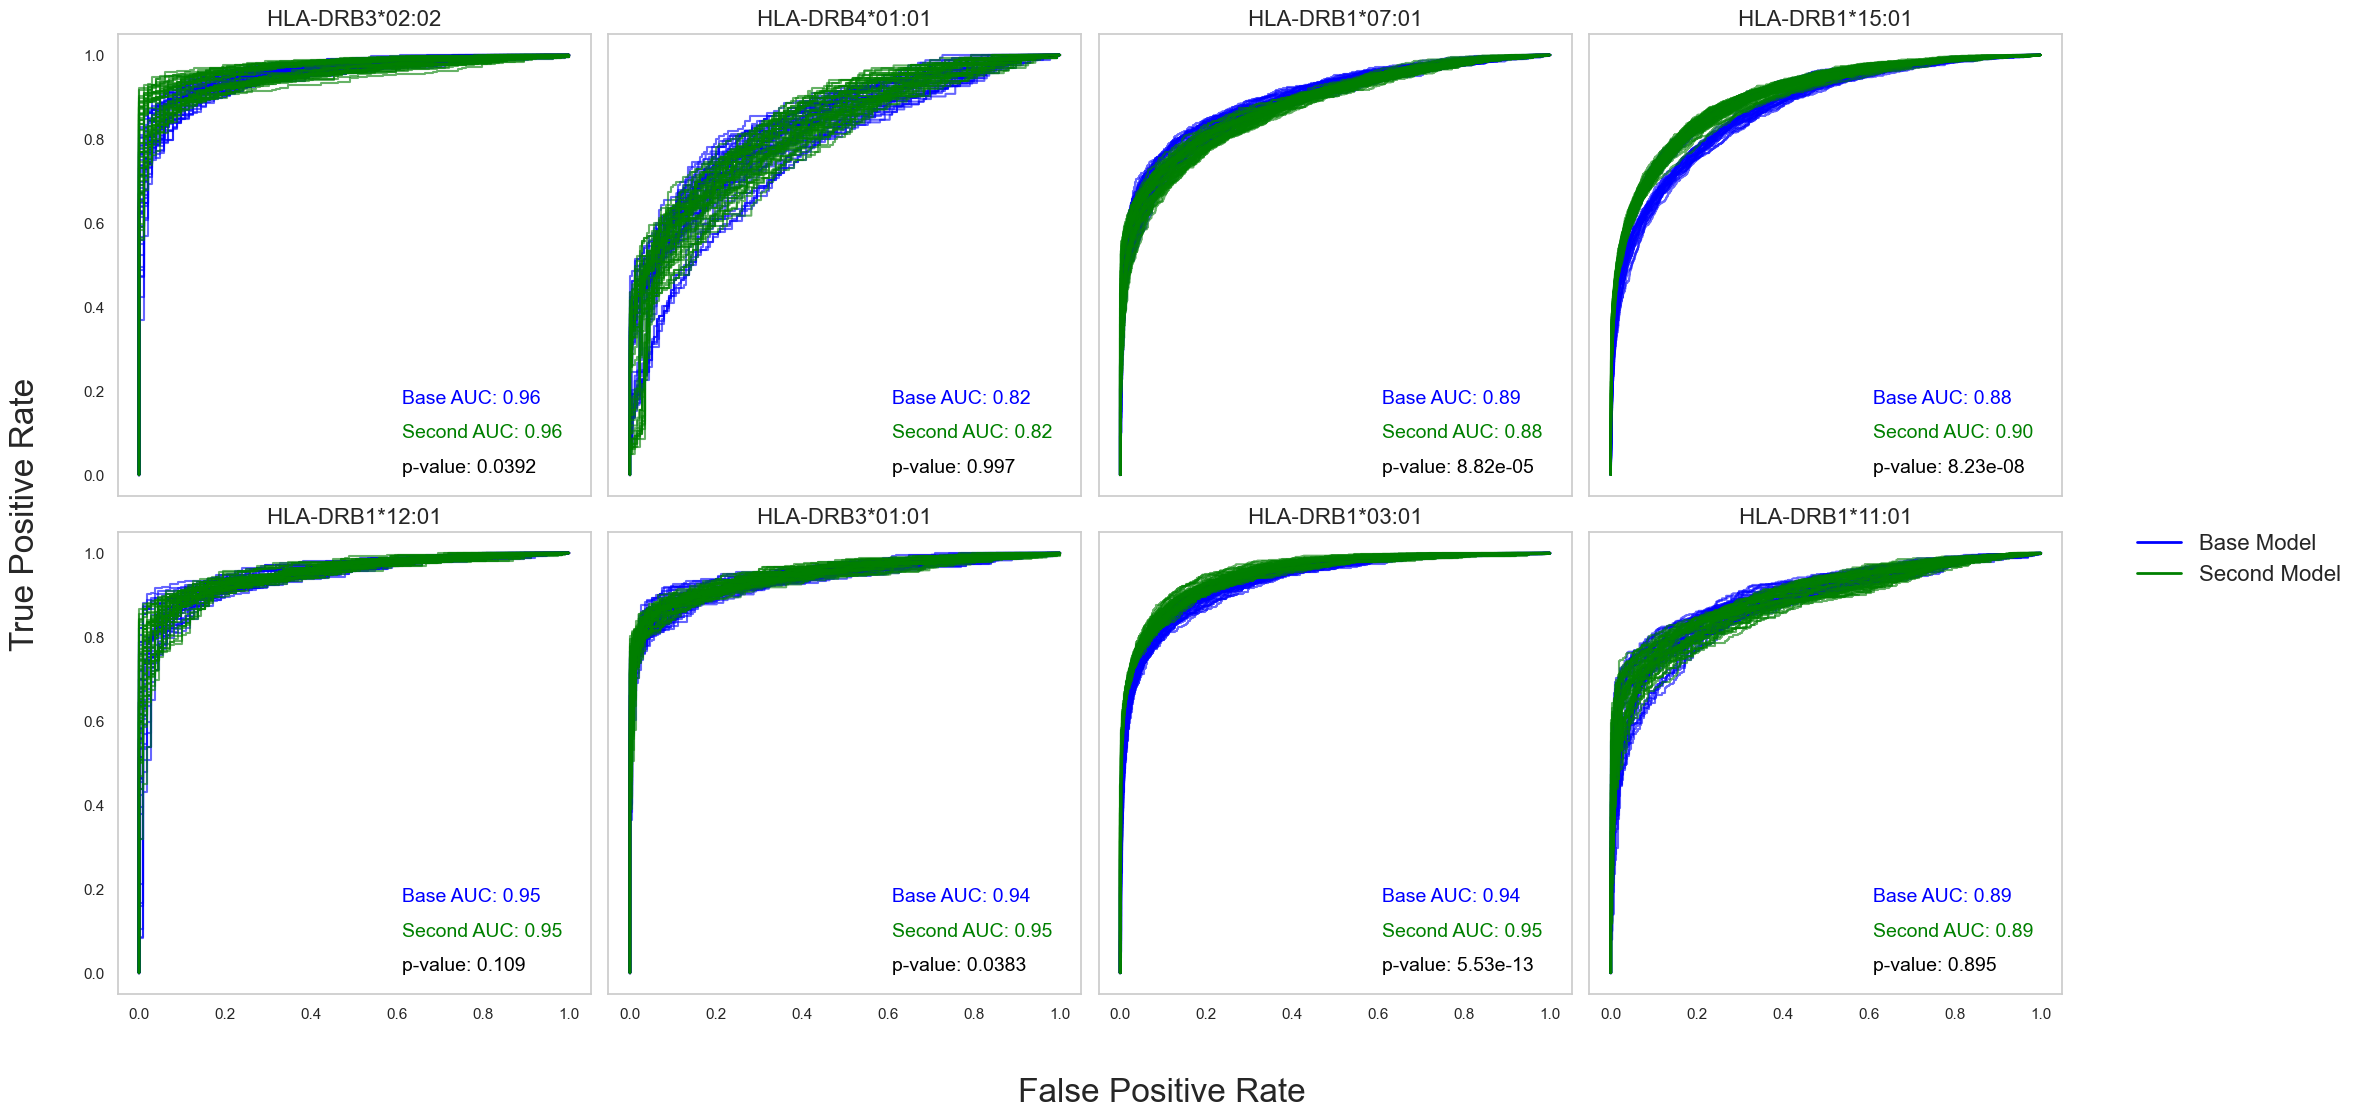

In [49]:
plot_roc_for_architectures(base_models, second_models, 'Combined')

In 2/8 models the second architecture demonstrated significant improved performance (HLA-DRB1*15:01 and HLA-DRB1*03:01 alleles). 

## The best HMM models vs MixMHXpred

In [55]:
best_models_per_allele = {}


mhc_path = r"C:\Projects\grandmaster\notebooks\MHC_predictor\metrics_and_scores\mixMHC"

metrics["mix_mhc"] = read_json("metrics.json", mhc_path)
results_score["mix_mhc"] = read_json("result_scores.json", mhc_path)
y_true["mix_mhc"] = read_json("y_true.json", mhc_path)

In [ ]:
alleles = set()
for model in metrics.keys():
    if model == "mix_mhc":
        continue  
    alleles.update(metrics[model].keys())


for allele in alleles:
    mean_aucs = {}
    for model, model_data in metrics.items():
        if model == "mix_mhc" or allele not in model_data:
            continue 
        auc_values = [split_data['auc'] for split_data in model_data[allele].values()]
        mean_aucs[model] = np.mean(auc_values)

    if mean_aucs:
        best_models_per_allele[allele] = max(mean_aucs, key=mean_aucs.get)

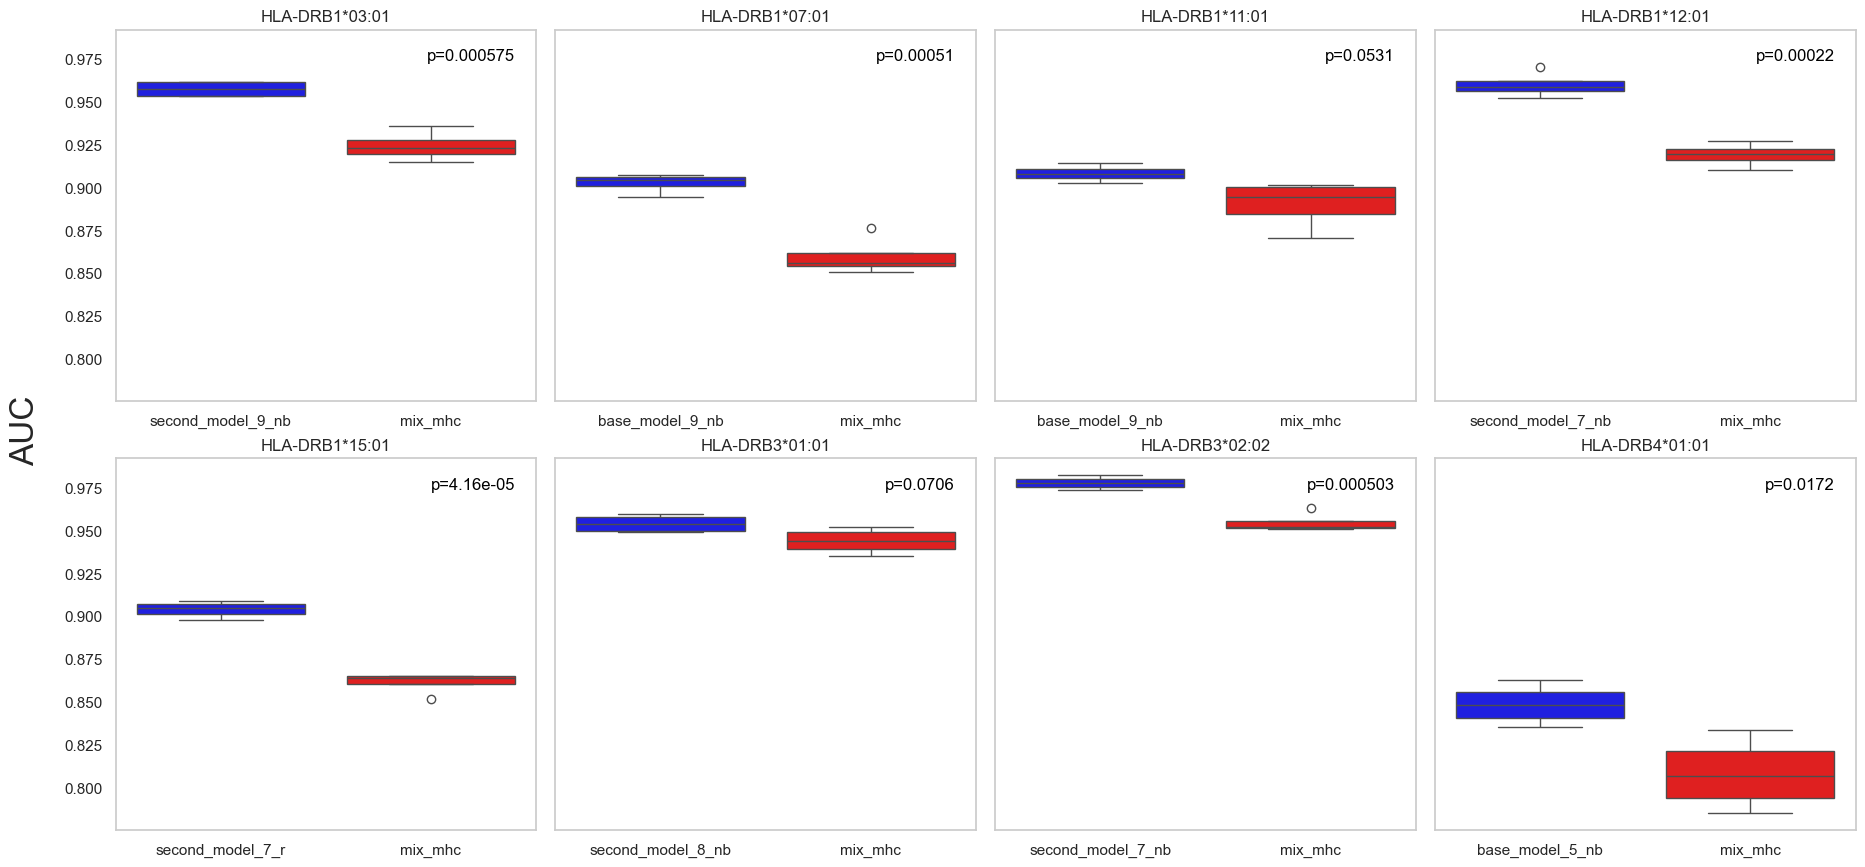

In [ ]:
num_alleles = len(best_models_per_allele)
cols = 4  
rows = 2 

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), sharey=True)
axes = axes.flatten()  

for i, (allele, best_model) in enumerate(sorted(best_models_per_allele.items())):
    best_model_aucs = [split_data['auc'] for split_data in metrics[best_model][allele].values()]
    mix_mhc_aucs = [split_data['auc'] for split_data in metrics["mix_mhc"][allele].values()]

    stat, p_value = ttest_ind(best_model_aucs, mix_mhc_aucs)  

    sns.boxplot(data=[best_model_aucs, mix_mhc_aucs], ax=axes[i], palette=["blue", "red"])
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels([best_model, "mix_mhc"])
    axes[i].set_title(f"{allele}")
    axes[i].grid(False)  
    
    axes[i].text(0.95, 0.95, f"p={p_value:.3g}", 
                 ha='right', va='top', transform=axes[i].transAxes, fontsize=12, color="black")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  

fig.text(0.02, 0.5, 'AUC', ha='center', va='center', rotation='vertical', fontsize=24)

for row in range(rows):
    for col in range(cols):
        ax_index = row * cols + col
        if ax_index < len(axes):
            ax = axes[ax_index]
            if col == 0:
                ax.tick_params(axis='y', labelleft=True)  
            else:
                ax.tick_params(axis='y', labelleft=False)  
            ax.grid(False)  

plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.subplots_adjust(left=0.065, right=0.935, bottom=0.1, top=0.9)
plt.savefig(f"plots//AUC_MHC.png", dpi=300)
plt.show()

In terms of AUC scores, the highest-performing HMM models demonstrate consistent superiority over the state-of-the-art MixMHCpred tool for various alleles